In [50]:
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kb_python.utils import import_matrix_as_anndata
from sklearn.linear_model import LinearRegression
from upsetplot import from_contents, from_indicators
from upsetplot import plot as upset
from scipy.stats import ttest_ind_from_stats
import anndata 
fsize = 12.5
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
import muon
from scipy import stats
from matplotlib.ticker import FuncFormatter

comma_fmt = FuncFormatter(lambda x, p: f"{x:.2E}")

def nd(arr):
    return np.asarray(arr).reshape(-1)


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, c="k", alpha=0.75, zorder=0)
    ax.set(**{"aspect": "equal", "xlim": lims, "ylim": lims})
    return ax


plt.rcParams.update({"font.size": fsize})
%config InlineBackend.figure_format = 'retina'

In [75]:
mu = muon.read_h5mu("/home/sina/projects/atac/scATAK/data/spatial/spatial.h5mu")

In [84]:
mat = mu.obs.pivot('atac:row', 'atac:col', 'atac:counts_nnzero').fillna(0).values

In [85]:
df = pd.read_csv("/home/sina/projects/atac/scATAK/data/spatial/GSM5238386_ME13_50um_spatial/spatial.data.txt", sep="\t")
M = df.pivot('row', 'col', 'counts_nnzero').fillna(0).values

In [80]:
pd.Series(np.abs(stats.zscore(mat, axis=None).sum(0) - stats.zscore(M, axis=None).sum(0))).nlargest(2)

24    74.426029
41    26.243768
dtype: float64

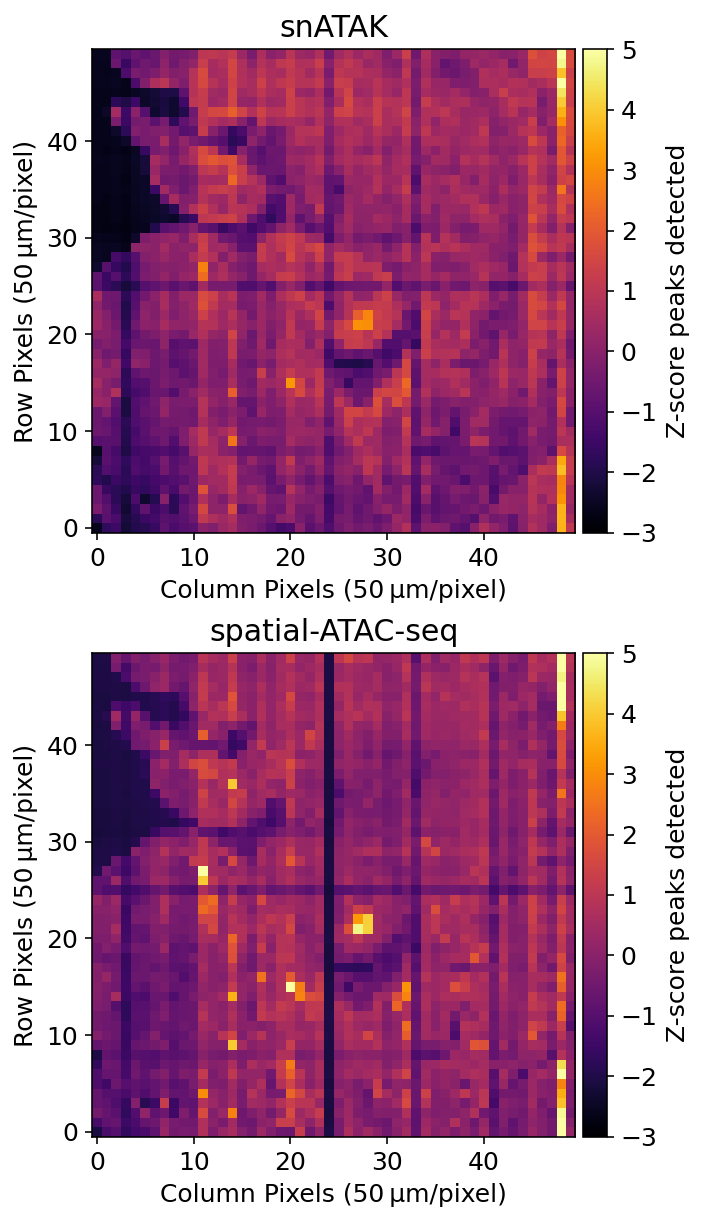

In [116]:
fig, axs = plt.subplots(figsize=(5,10), nrows=2)
fig.subplots_adjust(hspace=0.25)

ax = axs[0]
im = ax.matshow(stats.zscore(mat, axis=None), origin="lower", cmap="inferno", vmin = -3, vmax = 5)

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax, label="Z-score peaks detected")#, format=comma_fmt)

ax.set(**{
    "title": "snATAK",
    "xlabel": "Column Pixels (50 μm/pixel)",
    "ylabel": "Row Pixels (50 μm/pixel)"
})
ax.xaxis.set_ticks_position('bottom')

ax = axs[1]

im = ax.matshow(stats.zscore(M, axis=None), origin="lower", cmap="inferno", vmin = -3, vmax = 5)

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax, label="Z-score peaks detected")#, format=comma_fmt)
ax.set(**{
    "title": "spatial-ATAC-seq",
    "xlabel": "Column Pixels (50 μm/pixel)",
    "ylabel": "Row Pixels (50 μm/pixel)"
})
ax.xaxis.set_ticks_position('bottom')
fig.savefig("figures/spatial_cmp.png", bbox_inches='tight', dpi=300)
fig.show()

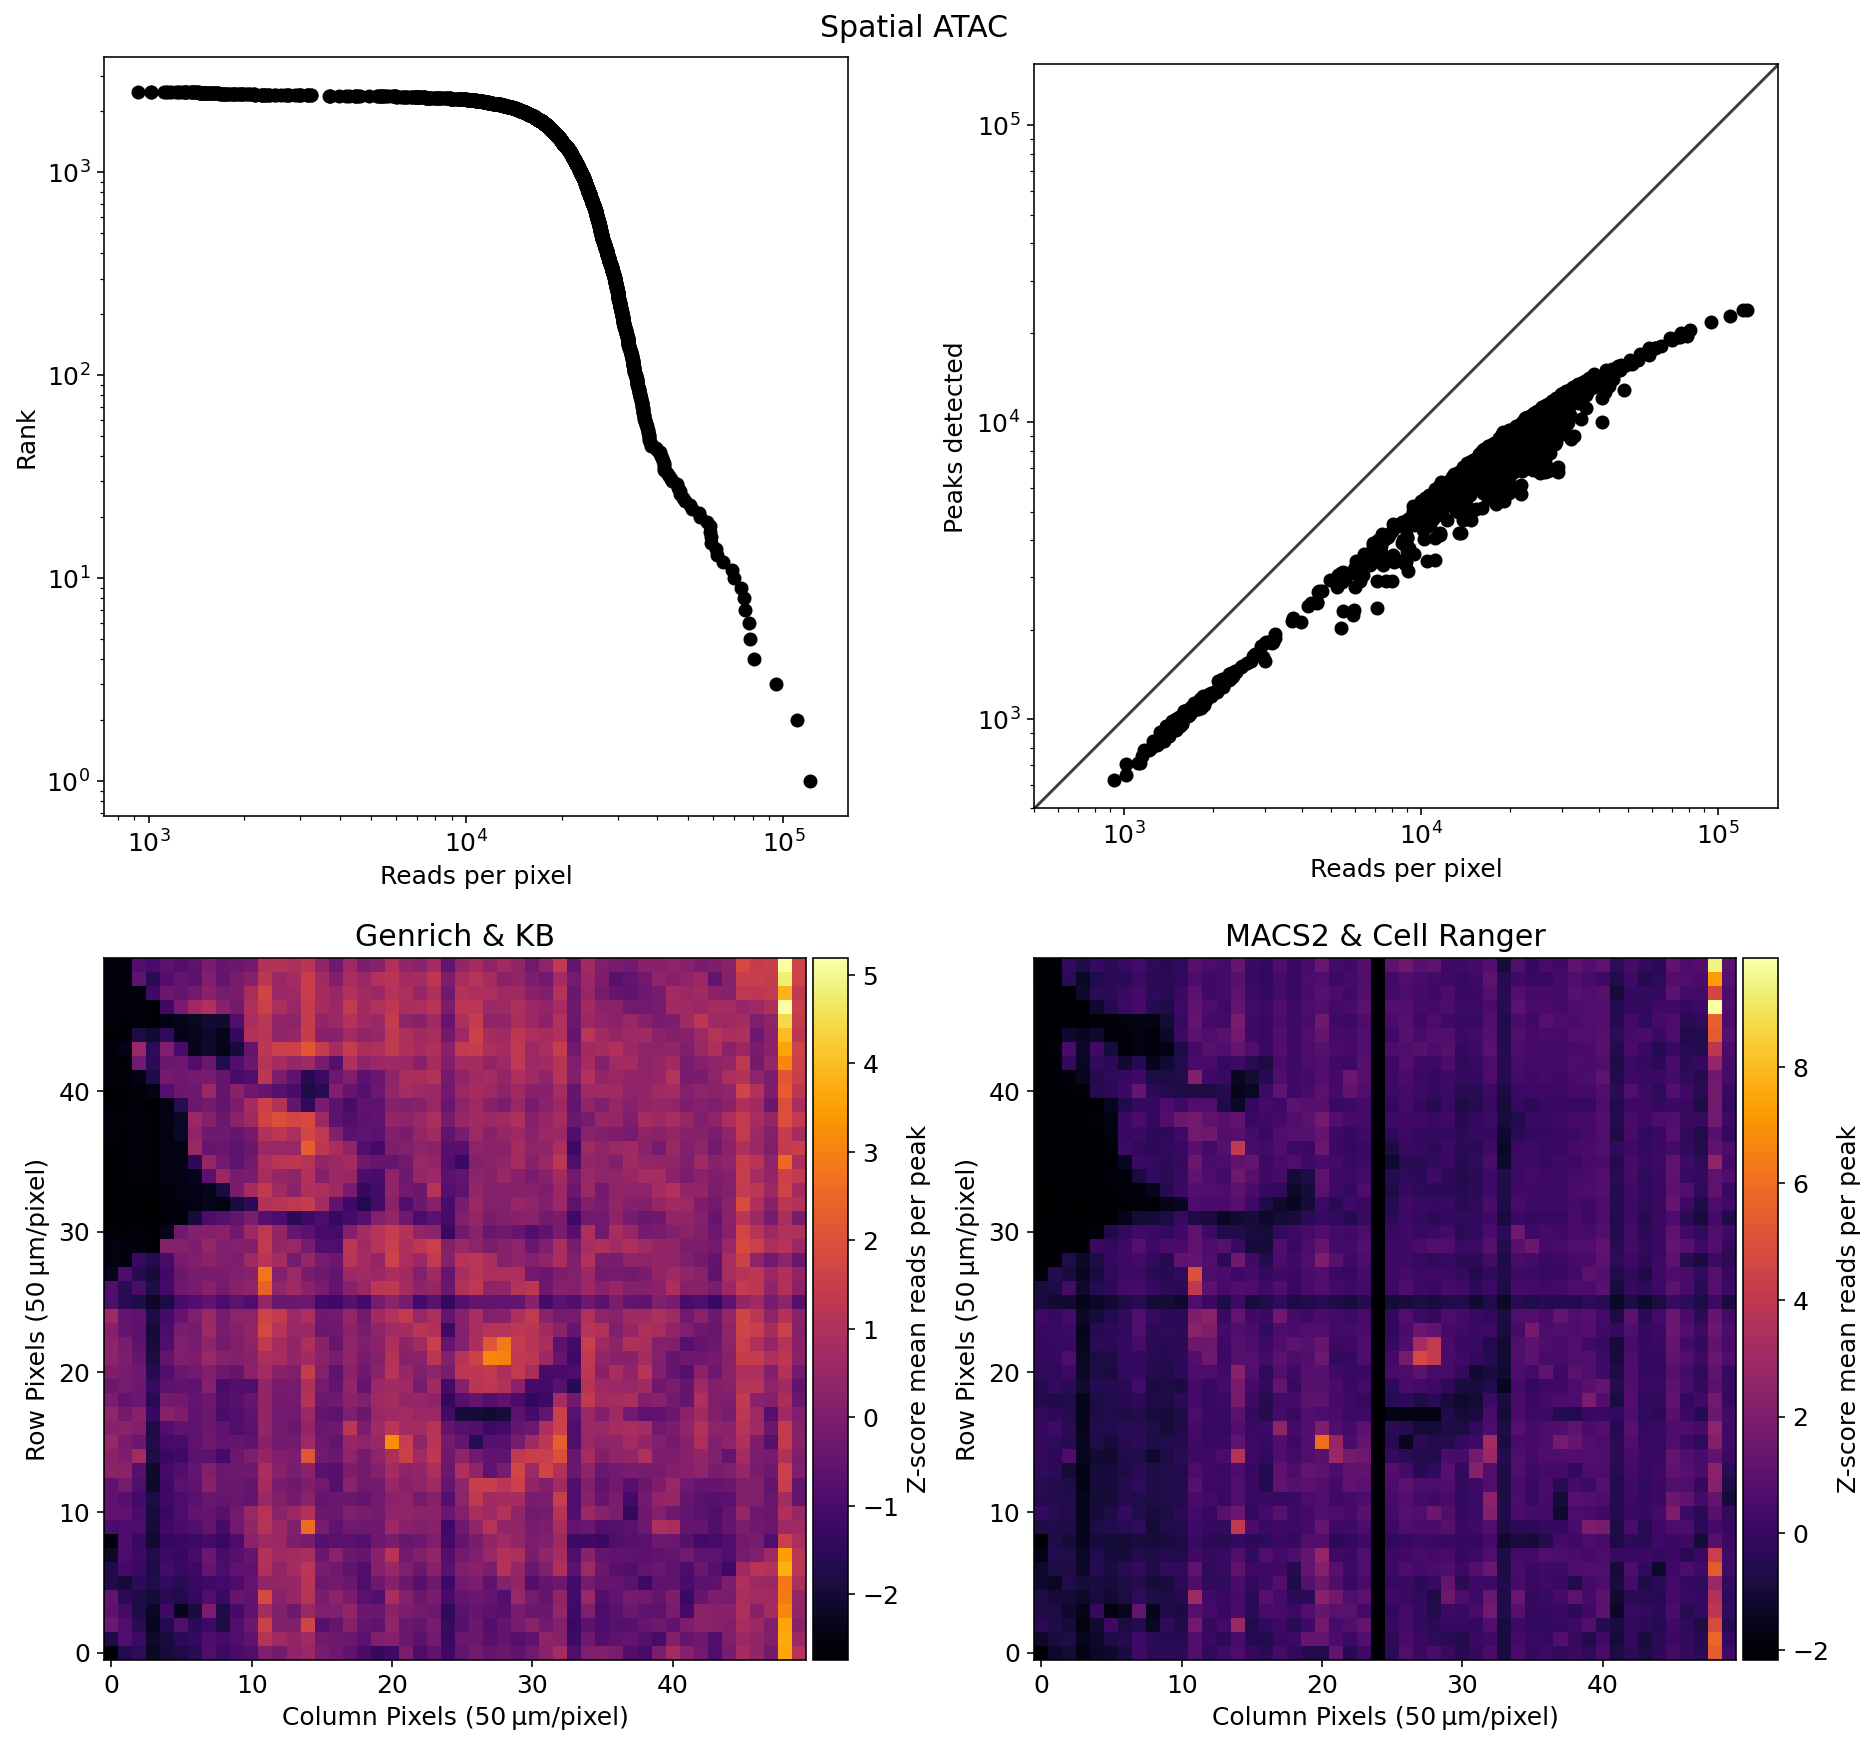

In [94]:
fig, axs = plt.subplots(figsize=(15,15), ncols=2, nrows=2)
fig.subplots_adjust(wspace=0.25, hspace=0.15)
fig.suptitle("Spatial ATAC", y=0.9)
ax = axs[0,0]

x = mu.obs["atac:counts_sum"].sort_values(ascending=False)
y = np.arange(x.shape[0])
ax.scatter(x,y, c="k")

ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "Reads per pixel",
    "ylabel": "Rank",
})
# ax.axvline(rna_lim[0], color="grey", linestyle="--")
# ax.axvline(rna_lim[1], color="grey", linestyle="--")

ax = axs[0,1]
x = mu.obs["atac:counts_sum"].values
y = mu.obs["atac:counts_nnzero"].values

ax.scatter(x,y, color="k")

kwd = {
    "xscale": "log",
    "yscale": "log",
    "xlabel": f"Reads per pixel",
    "ylabel": f"Peaks detected",
    "ylim": 500
}

ax.set(**kwd)
yex(ax)

ax = axs[1,0]
im = ax.matshow(stats.zscore(mat, axis=None), origin="lower", cmap="inferno")

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax, label="Z-score mean reads per peak")#, format=comma_fmt)

ax.set(**{
    "title": "Genrich & KB",
    "xlabel": "Column Pixels (50 μm/pixel)",
    "ylabel": "Row Pixels (50 μm/pixel)"
})
ax.xaxis.set_ticks_position('bottom')

ax = axs[1,1]

im = ax.matshow(stats.zscore(M, axis=None), origin="lower", cmap="inferno")

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax, label="Z-score mean reads per peak")#, format=comma_fmt)

ax.set(**{
    "title": "MACS2 & Cell Ranger",
    "xlabel": "Column Pixels (50 μm/pixel)",
    "ylabel": "Row Pixels (50 μm/pixel)"
})
ax.xaxis.set_ticks_position('bottom')

fig.show()

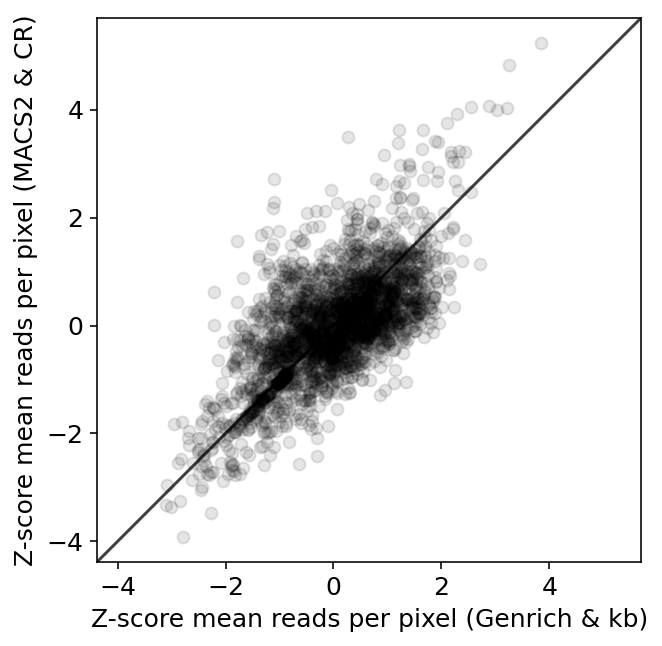

In [91]:
fig, ax = plt.subplots(figsize=(5,5))

x = stats.zscore(mat).ravel()
y = stats.zscore(M).ravel()

ax.scatter(x, y, color="k", alpha=0.1)

ax.set(**{
    "xlabel": "Z-score mean reads per pixel (Genrich & kb)",
    "ylabel": "Z-score mean reads per pixel (MACS2 & CR)",
    # "xscale": "log", 
    # "yscale": "log"
})
lx, ly = x.reshape(-1,1), y
reg = LinearRegression().fit(lx, ly)
r2 = reg.score(lx, ly)
yex(ax)
fig.show()

In [92]:
np.sqrt(r2)

0.6719561462839553